# Hill Climbing

---

In this notebook, we will train hill climbing with adaptive noise scaling with OpenAI Gym's Cartpole environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/Colab\ Notebooks/RL/hill-climbing

/content/drive/My Drive/Colab Notebooks/RL/hill-climbing


In [3]:
ls

Hill_Climbing.ipynb  README.md


### 1. Import the Necessary Packages

In [0]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym

    100% |████████████████████████████████| 450kB 15.2MB/s 
  gym 0.10.11 does not provide the extra 'box_2d'


### 2. Define the Policy

In [6]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with Stochastic Policy Search

In [7]:
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

policy = Policy()

def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            
scores = hill_climbing()

Episode 100	Average Score: 175.24
Environment solved in 13 episodes!	Average Score: 196.21


### 4. Plot the Scores

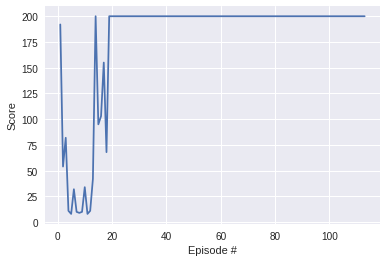

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [11]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [14]:
env = wrap_env(gym.make('CartPole-v0'))
env.seed(0)

[0]

In [15]:
#env = gym.make('CartPole-v0')
state = env.reset()
for t in range(200):
    action = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

show_video()